# Classification with extracted features

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import scipy.stats as scs
import feature_engineering as fe

from matplotlib  import cm
from collections import Counter
from importlib import reload
from nltk import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import scale, normalize, robust_scale
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

sns.set_context("paper")
%matplotlib inline

In [2]:
class_train = pd.read_csv('./data/train_variants')
text_train = pd.read_csv("./data/train_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])

In [3]:
feature_matrix1 = pd.read_csv('./data/feature_matrix_pass1.csv')

In [4]:
random_features = random.sample(list(feature_matrix1.columns), 30)
random_rows = random.sample(range(len(feature_matrix1)), 10)
feature_matrix1.loc[random_rows, random_features]

,ici164,mek5,lis,cryb2,cs07,iti,ectm,drug–kinase,pkd,osteoclastogenesis,...,siltuximab,pc146,nmri,fosl1,xl518,mut8,efcab3,eft,gabra6,rp3
1670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Try RandomForest on Raw Features Matrix

In [5]:
# Get Gene feature from 'train_variants' data
X_gene = np.array(class_train.Gene)
X_gene_int = LabelEncoder().fit_transform(X_gene.ravel()).reshape(-1, 1)
X_gene_bin = OneHotEncoder().fit_transform(X_gene_int).toarray()
gene_table = pd.DataFrame(X_gene_bin)

In [6]:
# Get Mutation Type from 'train_variants' data
import mskcc_functions as ski
new_table = ski.convert_mutation_type(class_train)
X_mtype = np.array(new_table['mutation_type'])
X_mtype_int = LabelEncoder().fit_transform(X_mtype.ravel()).reshape(-1, 1)
X_mtype_bin = OneHotEncoder().fit_transform(X_mtype_int).toarray()
mtype_table = pd.DataFrame(X_mtype_bin)

In [7]:
features1 = pd.concat([feature_matrix1, gene_table, mtype_table], axis=1)

In [8]:
X = np.array(features1).astype(float)
y = np.array(class_train.Class).astype(int).ravel()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=55)

In [10]:
%%time
rfc = RandomForestClassifier(n_estimators=100, max_depth=100, n_jobs=4)
rfc.fit(X_train, y_train)

CPU times: user 23.8 s, sys: 67.8 ms, total: 23.9 s
Wall time: 6.25 s


In [11]:
y_pred = rfc.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.482965931864


<b>Get rid of features with zero weights</b>

In [12]:
nonzero_features_ind = np.argwhere(rfc.feature_importances_ > 0)
rfc.feature_importances_[nonzero_features_ind]

array([[  5.75219498e-04],
       [  4.51443697e-06],
       [  1.58299195e-04],
       ..., 
       [  2.57197956e-04],
       [  7.08197880e-03],
       [  8.48858709e-06]])

In [13]:
type(nonzero_features_ind)

numpy.ndarray

In [16]:
rfc.feature_importances_[nonzero_features_ind]

array([[  5.75219498e-04],
       [  4.51443697e-06],
       [  1.58299195e-04],
       ..., 
       [  2.57197956e-04],
       [  7.08197880e-03],
       [  8.48858709e-06]])

In [17]:
print('Length of features: %d' % features1.shape[1])
print('Length of feature_importances_: %d' % len(rfc.feature_importances_))
print('Length of non-zero importance features: %d' % len(nonzero_features_ind))

Length of features: 22471
Length of feature_importances_: 22471
Length of non-zero importance features: 8294


In [18]:
features2 = features1.iloc[:, list(nonzero_features_ind.ravel())]
features2.shape

(3321, 8294)

In [19]:
X2 = np.array(features2).astype(float)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.15, random_state=55)

In [20]:
%%time
rfc2 = RandomForestClassifier(n_estimators=100, max_depth=100, n_jobs=4)
rfc2.fit(X_train2, y_train2)

CPU times: user 9.12 s, sys: 4.14 ms, total: 9.12 s
Wall time: 2.38 s


In [21]:
features2.shape

(3321, 8294)

In [22]:
y_pred2 = rfc2.predict(X_test2)
print(accuracy_score(y_test2, y_pred2))

0.480961923848


<b>SelectFromModel</b>

In [23]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.15, random_state=75)

In [24]:
clf = RandomForestClassifier(n_estimators=100, max_depth=100, n_jobs=4)
model = SelectFromModel(clf)

In [25]:
%%time
model.fit(X_train2, y_train2)

CPU times: user 8.96 s, sys: 7.03 ms, total: 8.97 s
Wall time: 2.37 s


SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
        prefit=False, threshold=None)

In [28]:
X2_select = model.transform(X2)
print(X2_select.shape)
print(model.threshold_)

(3321, 1452)
0.000120569086086


Use 0.0012 as threshhold for feature selection from rfc2

In [29]:
features_ind3 = np.argwhere(rfc2.feature_importances_ >= 0.00012)
print(len(features_ind3))

features3 = features2.iloc[:, list(features_ind3.ravel())]
print(features3.shape)

1438
(3321, 1438)


In [30]:
X3 = np.array(features3).astype(float)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y, test_size=0.15, random_state=75)

In [31]:
%%time
rfc3 = RandomForestClassifier(n_estimators=100, max_depth=100, n_jobs=4)
rfc3.fit(X_train3, y_train3)

CPU times: user 2.5 s, sys: 8.74 ms, total: 2.51 s
Wall time: 755 ms


In [32]:
y_pred3 = rfc3.predict(X_test3)
print(accuracy_score(y_test3, y_pred3))

0.50501002004


With robust_scale

In [33]:
features3 = features2.iloc[:, list(features_ind3.ravel())]
print(features3.shape)

(3321, 1438)


In [34]:
X3_scaled = robust_scale(X3)
X_train3s, X_test3s, y_train3s, y_test3s = train_test_split(X3_scaled, y, test_size=0.1, random_state=75)

In [35]:
%%time
rfc3s = RandomForestClassifier(n_estimators=50, max_depth=100, n_jobs=4)
rfc3s.fit(X_train3s, y_train3s)

CPU times: user 1.52 s, sys: 8.64 ms, total: 1.53 s
Wall time: 431 ms


In [36]:
y_pred3s = rfc3s.predict(X_test3s)
print(accuracy_score(y_test3s, y_pred3s))

0.459459459459


Try PCA

In [37]:
features3['p53']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
5        0.0
6        0.0
7        0.0
8        0.0
9        0.0
10       0.0
11       7.0
12       7.0
13       0.0
14       0.0
15       0.0
16       0.0
17       0.0
18       0.0
19       0.0
20       0.0
21       0.0
22       0.0
23       0.0
24       0.0
25       0.0
26       1.0
27       0.0
28       0.0
29       0.0
        ... 
3291     0.0
3292     0.0
3293     0.0
3294     0.0
3295     0.0
3296     0.0
3297     0.0
3298     0.0
3299     0.0
3300     0.0
3301     0.0
3302     0.0
3303     0.0
3304     0.0
3305     0.0
3306     0.0
3307     1.0
3308     0.0
3309     1.0
3310     1.0
3311     1.0
3312     0.0
3313     0.0
3314     0.0
3315     0.0
3316     0.0
3317     7.0
3318     0.0
3319     1.0
3320    34.0
Name: p53, Length: 3321, dtype: float64

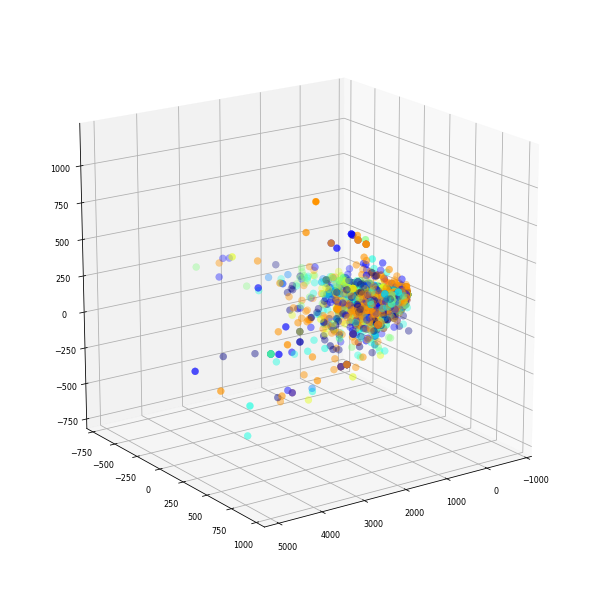

In [38]:
# Create a new table with ID as index
pca_table4 = pd.DataFrame(index=class_train.ID)
pca = PCA(n_components=3)
pca.fit(X3)
pca_table4['x'] = pca.fit_transform(X3).T[0]
pca_table4['y'] = pca.fit_transform(X3).T[1]
pca_table4['z'] = pca.fit_transform(X3).T[2]

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, elev=18, azim=55)#, rect=[0, 0, .95, 1])

ax.scatter(pca_table4.x, pca_table4.y, pca_table4.z, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet)

Some variance analysis

In [39]:
feat_var = features3.var(axis=0)
feat_var.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count      1438.000000
mean        301.032425
std        4710.894521
min           0.000301
25%           0.360865
50%           2.479377
75%          19.249406
90%         118.642329
95%         310.466751
99%        2973.438910
max      138280.942286
dtype: float64

(0, 100)

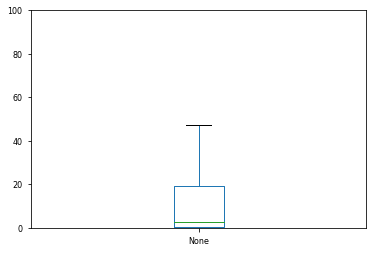

In [40]:
feat_var.plot(kind='box')
plt.ylim([0, 100])

In [41]:
len(feat_var[feat_var > 20])

356

(0, 30)

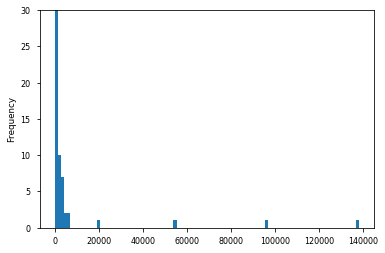

In [42]:
feat_var.plot(kind='hist', bins=100)
#plt.xlim([0,1000])
plt.ylim([0, 30])

In [43]:
features4_ind = features3.columns[features3.var(axis=0) > 20]

In [44]:
features4 = features3[features4_ind]
print(features4.shape)

(3321, 356)


In [45]:
X4 = np.array(features4).astype(float)
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y, test_size=0.15, random_state=75)

In [46]:
%%time
rfc4 = RandomForestClassifier(n_estimators=100, max_depth=100, n_jobs=4)
rfc4.fit(X_train4, y_train4)

CPU times: user 1.27 s, sys: 4.99 ms, total: 1.27 s
Wall time: 457 ms


In [47]:
y_pred4 = rfc4.predict(X_test4)
print(accuracy_score(y_test4, y_pred4))

0.458917835671


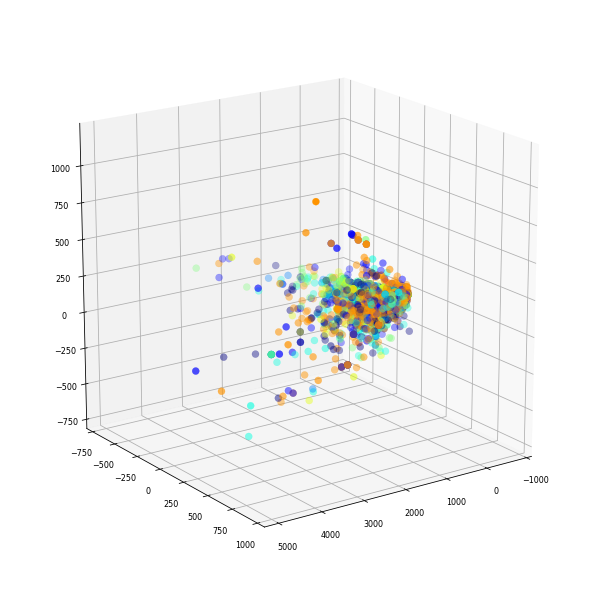

In [48]:
# Create a new table with ID as index
pca_table4 = pd.DataFrame(index=class_train.ID)
pca = PCA(n_components=3)
pca.fit(X4)
pca_table4['x'] = pca.fit_transform(X4).T[0]
pca_table4['y'] = pca.fit_transform(X4).T[1]
pca_table4['z'] = pca.fit_transform(X4).T[2]

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, elev=18, azim=55)#, rect=[0, 0, .95, 1])

ax.scatter(pca_table4.x, pca_table4.y, pca_table4.z, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet)

<b>Hmm... back to exploring feature space</b>

In [52]:
classes = class_train.Class
table = pd.concat([features1, classes], axis=1)
table.shape

(3321, 22472)

In [141]:
class_feature_counts = []
for i in range(9):
    class_feature_counts.append(table[table['Class'] == (i+1)].sum(axis=0))

In [142]:
feature_counts_by_class = pd.concat(class_feature_counts, axis=1).transpose()

In [144]:
feature_counts_by_class['Class']

0     567.0
1     902.0
2     264.0
3    2740.0
4    1205.0
5    1644.0
6    6664.0
7     144.0
8     324.0
Name: Class, dtype: float64

In [145]:
del feature_counts_by_class['Class']
feature_counts_by_class.head()

,aa,aa0869,aa1077,aa1370,aa2800,aa491,aa499,aa8,aaa,aaalac,...,7,8,9,10,11,12,13,14,15,16
0,483.0,1.0,8.0,0.0,1.0,0.0,0.0,0.0,53.0,0.0,...,1.0,0.0,1.0,0.0,0.0,403.0,0.0,2.0,91.0,0.0
1,194.0,3.0,24.0,1.0,0.0,0.0,0.0,19.0,51.0,0.0,...,76.0,1.0,3.0,1.0,2.0,303.0,0.0,0.0,3.0,0.0
2,110.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,87.0,0.0,0.0,0.0,1.0
3,641.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,41.0,0.0,...,3.0,2.0,2.0,0.0,0.0,630.0,0.0,2.0,1.0,0.0
4,538.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,238.0,0.0,0.0,0.0,0.0


In [204]:
feature_uniqueness = feature_counts_by_class.astype(bool).sum(axis=0)
feature_total_counts = feature_counts_by_class.sum(axis=0)

discriminating_feature_ind = list(np.argwhere(feature_uniqueness <= 5).ravel())
minimum_appearance_feature_ind = list(np.argwhere(feature_total_counts >= 20).ravel())
print(len(discriminating_feature_ind))
print(len(minimum_appearance_feature_ind))

feature_meeting_conditions = set(discriminating_feature_ind).intersection(set(minimum_appearance_feature_ind))
useful_feature_ind = sorted(list(feature_meeting_conditions))
print(len(useful_feature_ind))

X5 = X[:, useful_feature_ind]

18693
6302
2693


In [205]:
X5.shape

(3321, 2693)

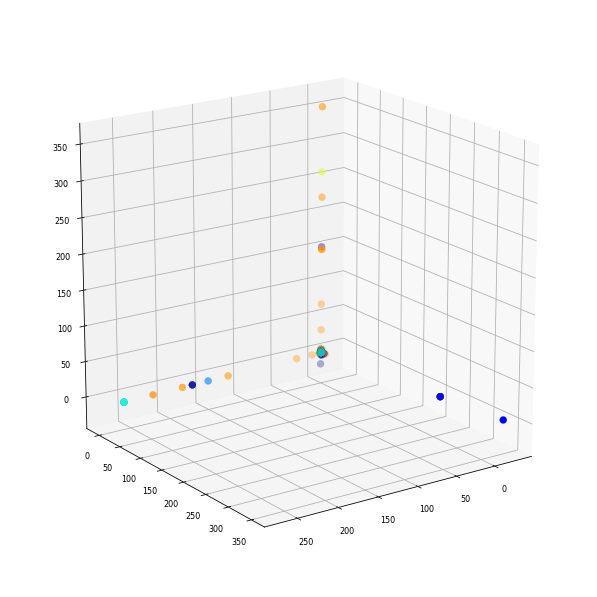

In [206]:
# Create a new table with ID as index
pca_table4 = pd.DataFrame(index=class_train.ID)
pca = PCA(n_components=3)
pca.fit(X5)
pca_table4['x'] = pca.fit_transform(X5).T[0]
pca_table4['y'] = pca.fit_transform(X5).T[1]
pca_table4['z'] = pca.fit_transform(X5).T[2]

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, elev=18, azim=55)#, rect=[0, 0, .95, 1])

ax.scatter(pca_table4.x, pca_table4.y, pca_table4.z, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet)

In [207]:
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y, test_size=0.15, random_state=75)

In [208]:
%%time
rfc5 = RandomForestClassifier(n_jobs=4)
rfc5.fit(X_train5, y_train5)

CPU times: user 797 ms, sys: 7.75 ms, total: 804 ms
Wall time: 321 ms


In [209]:
y_pred5 = rfc5.predict(X_test5)
print(accuracy_score(y_test5, y_pred5))

0.464929859719


Try Naive Bayes

In [210]:
from sklearn.naive_bayes import MultinomialNB

In [211]:
nb = MultinomialNB()
nb.fit(X_train5, y_train5)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [197]:
y_pred5nb = nb.predict(X_test5)
print(accuracy_score(y_test5, y_pred5nb))

0.338677354709
